In [1]:
import requests
import json
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

# COVID Data: Processing and Exploratory Data Analysis

## Import and merge data

In [2]:
nhs=pd.read_csv('nhsRegion_2022-04-01.csv')
region= pd.read_csv('region_2022-04-01.csv')
ulta=pd.read_csv('utla_2022-04-01.csv')
vac=pd.read_csv('data_2022-Apr-05.csv')

In [3]:
def get_API_data(filters, structure):
    endpoint = "https://api.coronavirus.data.gov.uk/v1/data"
    # pack parameters
    api_params = {
        "filters": str.join(";", filters),
        "structure": json.dumps(structure, separators=(",", ":")),
        "page":1
        }
    response = requests.get(endpoint, params=api_params, timeout = 50)  # send request
    
    # running into problem when status_code >=400
    if response.status_code >= 400:
        raise RuntimeError(f'Request failed: { response.text }')
        
    result = response.json()
    return result['data']

In [4]:
query_filters = ['areaType=region','areaName=London']
# the data we require
query_structure = {
    "date": "date",
    "name": "areaName",
    "daily_cases": "newCasesBySpecimenDate",
    "daily_cases_age": "newCasesBySpecimenDateAgeDemographics",
    "cumulative_cases": "cumCasesBySpecimenDate",
    "daily_deaths": "newDeaths28DaysByPublishDate",
    "daily_deaths_age": "newDeaths28DaysByDeathDateAgeDemographics",
    "cumulative_deaths": "cumDeaths28DaysByPublishDate",
    "cumulative_vaccinated": "cumPeopleVaccinatedSecondDoseByVaccinationDate",
    "vaccination_age": "vaccinationsAgeDemographics"
}
# get national data
results_json = get_API_data(query_filters, query_structure)

In [5]:
london_covid = pd.json_normalize(results_json)
london_covid.dropna(inplace=True)
london_covid

,date,name,daily_cases,daily_cases_age,cumulative_cases,daily_deaths,daily_deaths_age,cumulative_deaths,cumulative_vaccinated,vaccination_age
1,2022-04-07,London,2111.0,[],2823873.0,35.0,[],19510.0,6002436.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
2,2022-04-06,London,3836.0,[],2821762.0,265.0,[],19475.0,6001210.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
3,2022-04-05,London,4445.0,[],2817926.0,22.0,[],19210.0,6000016.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
4,2022-04-04,London,5146.0,[],2813481.0,11.0,[],19188.0,5998538.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
5,2022-04-03,London,3881.0,"[{'age': '00_04', 'cases': 53, 'rollingSum': 7...",2808335.0,0.0,"[{'age': '00_04', 'deaths': 0, 'rollingSum': 0...",19177.0,5997029.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
...,...,...,...,...,...,...,...,...,...,...
482,2020-12-12,London,4749.0,"[{'age': '00_04', 'cases': 137, 'rollingSum': ...",211609.0,28.0,"[{'age': '00_04', 'deaths': 0, 'rollingSum': 0...",7424.0,1353.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
483,2020-12-11,London,5538.0,"[{'age': '00_04', 'cases': 151, 'rollingSum': ...",206860.0,34.0,"[{'age': '00_04', 'deaths': 0, 'rollingSum': 0...",7396.0,1353.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
484,2020-12-10,London,5080.0,"[{'age': '00_04', 'cases': 140, 'rollingSum': ...",201322.0,40.0,"[{'age': '00_04', 'deaths': 0, 'rollingSum': 0...",7362.0,1353.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
485,2020-12-09,London,4462.0,"[{'age': '00_04', 'cases': 119, 'rollingSum': ...",196242.0,35.0,"[{'age': '00_04', 'deaths': 0, 'rollingSum': 0...",7322.0,1344.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."


In [6]:
london_covid.date=pd.to_datetime(london_covid.date, infer_datetime_format=True)
region.date=pd.to_datetime(region.date, infer_datetime_format=True)
vac.date=pd.to_datetime(vac.date, infer_datetime_format=True)
nhs.date=pd.to_datetime(nhs.date, infer_datetime_format=True)

In [7]:
covid=london_covid.merge(vac, left_on='date', right_on='date')

In [8]:
covid.columns.tolist()

['date',
 'name',
 'daily_cases',
 'daily_cases_age',
 'cumulative_cases',
 'daily_deaths',
 'daily_deaths_age',
 'cumulative_deaths',
 'cumulative_vaccinated',
 'vaccination_age',
 'areaType',
 'areaName',
 'areaCode',
 'newPeopleVaccinatedFirstDoseByVaccinationDate',
 'cumPeopleVaccinatedFirstDoseByVaccinationDate',
 'newPeopleVaccinatedSecondDoseByVaccinationDate',
 'cumPeopleVaccinatedSecondDoseByVaccinationDate',
 'newPeopleVaccinatedThirdInjectionByVaccinationDate',
 'cumPeopleVaccinatedThirdInjectionByVaccinationDate']

In [9]:
covid=covid.merge(nhs, left_on='date', right_on='date')

In [10]:
covid_select=covid[['date','name','daily_cases','cumulative_cases','daily_deaths',
                    'cumulative_deaths','newPeopleVaccinatedFirstDoseByVaccinationDate',
                   'cumPeopleVaccinatedFirstDoseByVaccinationDate',
 'newPeopleVaccinatedSecondDoseByVaccinationDate',
 'cumPeopleVaccinatedSecondDoseByVaccinationDate',
 'newPeopleVaccinatedThirdInjectionByVaccinationDate',
 'cumPeopleVaccinatedThirdInjectionByVaccinationDate','covidOccupiedMVBeds','hospitalCases','newAdmissions','newAdmissionsRollingSum']]
covid_select

,date,name,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,newPeopleVaccinatedFirstDoseByVaccinationDate,cumPeopleVaccinatedFirstDoseByVaccinationDate,newPeopleVaccinatedSecondDoseByVaccinationDate,cumPeopleVaccinatedSecondDoseByVaccinationDate,newPeopleVaccinatedThirdInjectionByVaccinationDate,cumPeopleVaccinatedThirdInjectionByVaccinationDate,covidOccupiedMVBeds,hospitalCases,newAdmissions,newAdmissionsRollingSum
0,2022-04-01,London,5039.0,2800726.0,11.0,19177.0,750,6448275,1986,5993754,2542.0,4276592.0,99.0,2448.0,NaN,NaN
1,2022-03-31,London,5726.0,2795687.0,5.0,19166.0,645,6447525,1558,5991768,2168.0,4274050.0,100.0,2434.0,NaN,NaN
2,2022-03-30,London,7908.0,2789961.0,9.0,19161.0,613,6446880,1573,5990210,2390.0,4271882.0,104.0,2330.0,231.0,1563.0
3,2022-03-29,London,8372.0,2782053.0,18.0,19152.0,533,6446267,1589,5988637,2465.0,4269492.0,109.0,2324.0,264.0,1543.0
4,2022-03-28,London,9453.0,2773681.0,14.0,19134.0,590,6445734,1603,5987048,2659.0,4267027.0,103.0,2266.0,263.0,1492.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,2020-12-12,London,4749.0,211609.0,28.0,7424.0,863,6805,0,1350,NaN,NaN,256.0,2092.0,246.0,1598.0
476,2020-12-11,London,5538.0,206860.0,34.0,7396.0,1433,5942,0,1350,NaN,NaN,261.0,2031.0,277.0,1493.0
477,2020-12-10,London,5080.0,201322.0,40.0,7362.0,1409,4509,9,1350,NaN,NaN,256.0,1934.0,235.0,1386.0
478,2020-12-09,London,4462.0,196242.0,35.0,7322.0,878,3100,9,1341,NaN,NaN,241.0,1787.0,248.0,1307.0


In [11]:
covid_select = covid_select.rename(columns={'newPeopleVaccinatedFirstDoseByVaccinationDate': 'FirstDose', 
                                            'cumPeopleVaccinatedFirstDoseByVaccinationDate': 'cumFirstDose',
                                            'newPeopleVaccinatedSecondDoseByVaccinationDate': 'SecondDose',
 'cumPeopleVaccinatedSecondDoseByVaccinationDate':'cumSecondDose',
 'newPeopleVaccinatedThirdInjectionByVaccinationDate':'ThirdDose',
 'cumPeopleVaccinatedThirdInjectionByVaccinationDate':'cumThirdDose'
                                           })

### Exploratory plotting

In [12]:
covid_select

,date,name,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,FirstDose,cumFirstDose,SecondDose,cumSecondDose,ThirdDose,cumThirdDose,covidOccupiedMVBeds,hospitalCases,newAdmissions,newAdmissionsRollingSum
0,2022-04-01,London,5039.0,2800726.0,11.0,19177.0,750,6448275,1986,5993754,2542.0,4276592.0,99.0,2448.0,NaN,NaN
1,2022-03-31,London,5726.0,2795687.0,5.0,19166.0,645,6447525,1558,5991768,2168.0,4274050.0,100.0,2434.0,NaN,NaN
2,2022-03-30,London,7908.0,2789961.0,9.0,19161.0,613,6446880,1573,5990210,2390.0,4271882.0,104.0,2330.0,231.0,1563.0
3,2022-03-29,London,8372.0,2782053.0,18.0,19152.0,533,6446267,1589,5988637,2465.0,4269492.0,109.0,2324.0,264.0,1543.0
4,2022-03-28,London,9453.0,2773681.0,14.0,19134.0,590,6445734,1603,5987048,2659.0,4267027.0,103.0,2266.0,263.0,1492.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,2020-12-12,London,4749.0,211609.0,28.0,7424.0,863,6805,0,1350,NaN,NaN,256.0,2092.0,246.0,1598.0
476,2020-12-11,London,5538.0,206860.0,34.0,7396.0,1433,5942,0,1350,NaN,NaN,261.0,2031.0,277.0,1493.0
477,2020-12-10,London,5080.0,201322.0,40.0,7362.0,1409,4509,9,1350,NaN,NaN,256.0,1934.0,235.0,1386.0
478,2020-12-09,London,4462.0,196242.0,35.0,7322.0,878,3100,9,1341,NaN,NaN,241.0,1787.0,248.0,1307.0


<AxesSubplot:xlabel='date'>

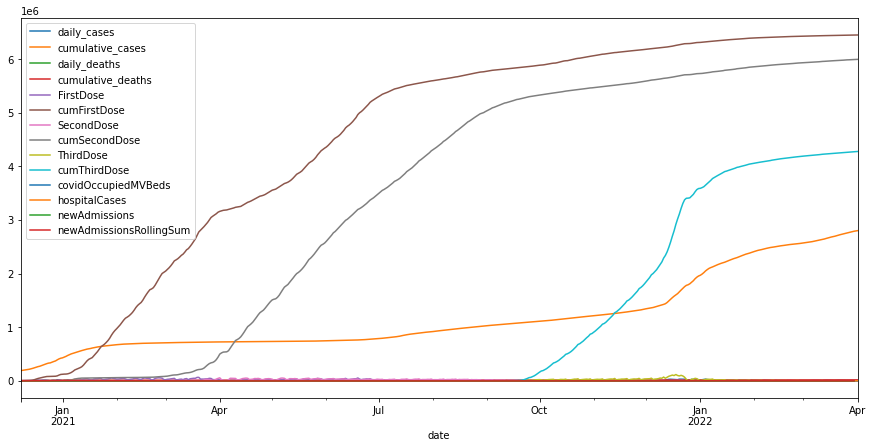

In [13]:
covid_select.set_index('date').plot(figsize=(15,7))


In [14]:
covid_daily =covid_select[['date','daily_cases','daily_deaths','FirstDose','SecondDose','ThirdDose','covidOccupiedMVBeds',
                           'hospitalCases','newAdmissions']]

<AxesSubplot:xlabel='date'>

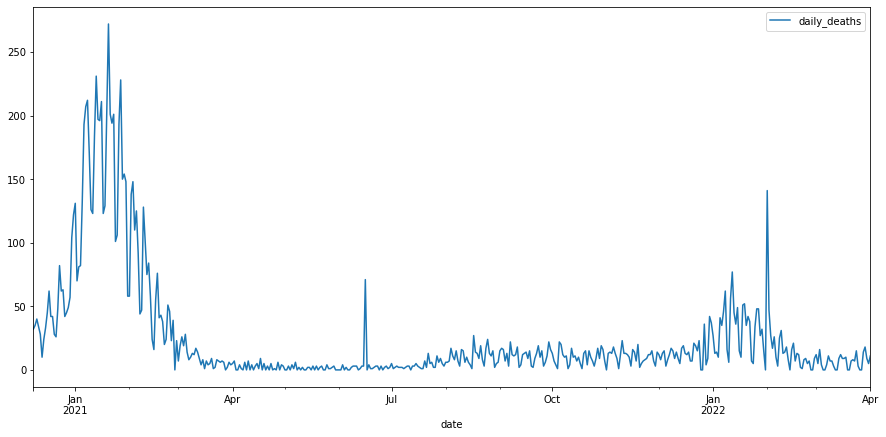

In [15]:
covid_daily.set_index('date').plot(figsize=(15,7),y=['daily_deaths'])

<AxesSubplot:xlabel='date'>

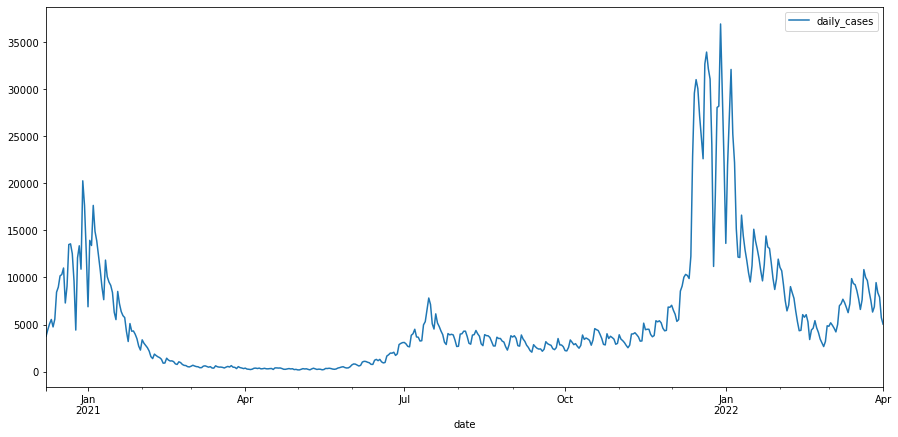

In [16]:
covid_daily.set_index('date').plot(figsize=(15,7),y=['daily_cases'])

<AxesSubplot:xlabel='date'>

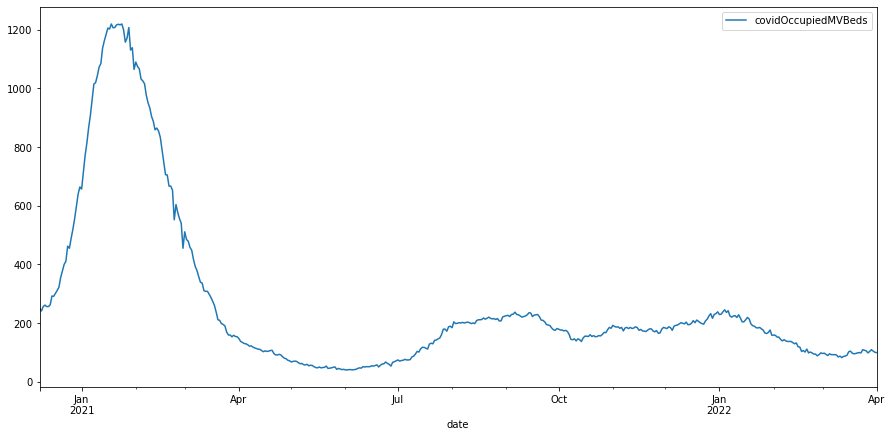

In [17]:
covid_daily.set_index('date').plot(figsize=(15,7),y=['covidOccupiedMVBeds'])

<AxesSubplot:xlabel='date'>

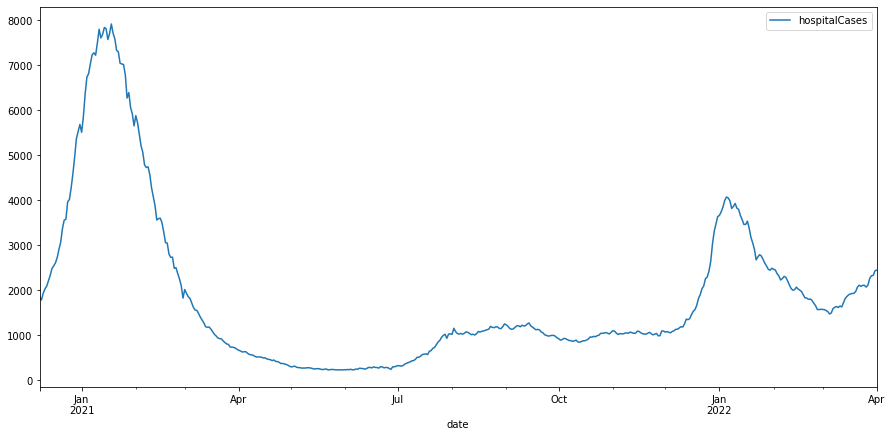

In [18]:
covid_daily.set_index('date').plot(figsize=(15,7),y=['hospitalCases'])

<AxesSubplot:xlabel='date'>

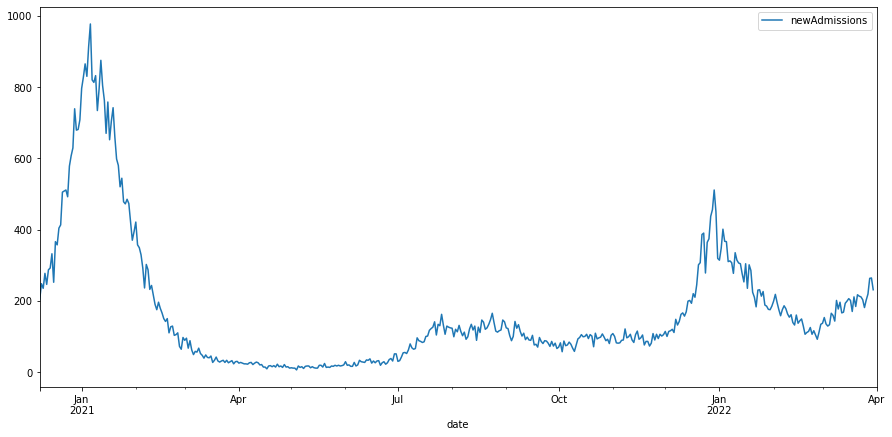

In [19]:
covid_daily.set_index('date').plot(figsize=(15,7),y=['newAdmissions'])

<AxesSubplot:xlabel='date'>

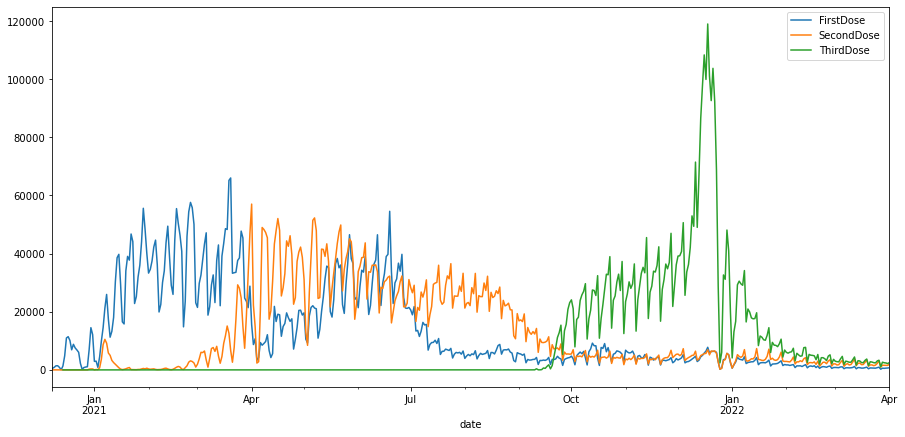

In [20]:
covid_daily.set_index('date').plot(figsize=(15,7),y=['FirstDose','SecondDose','ThirdDose'])

<AxesSubplot:>

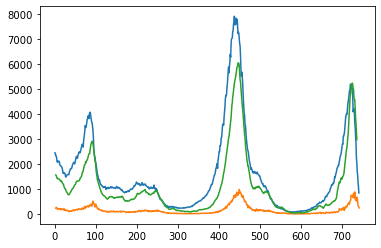

In [21]:
nhs.hospitalCases.plot()
nhs.newAdmissions.plot()
nhs.newAdmissionsRollingSum.plot()

In [22]:
region.describe()

,newCasesByPublishDate,newCasesBySpecimenDate,newCasesBySpecimenDateRollingSum
count,715.000000,788.000000,778.000000
mean,3877.001399,3541.335025,24666.787918
std,7028.395818,5493.730567,37058.711326
min,0.000000,0.000000,1.000000
25%,289.000000,293.750000,2064.000000
50%,2069.000000,1590.500000,11952.000000
75%,4272.000000,4027.000000,27219.250000
max,128076.000000,36919.000000,204554.000000


<AxesSubplot:xlabel='date'>

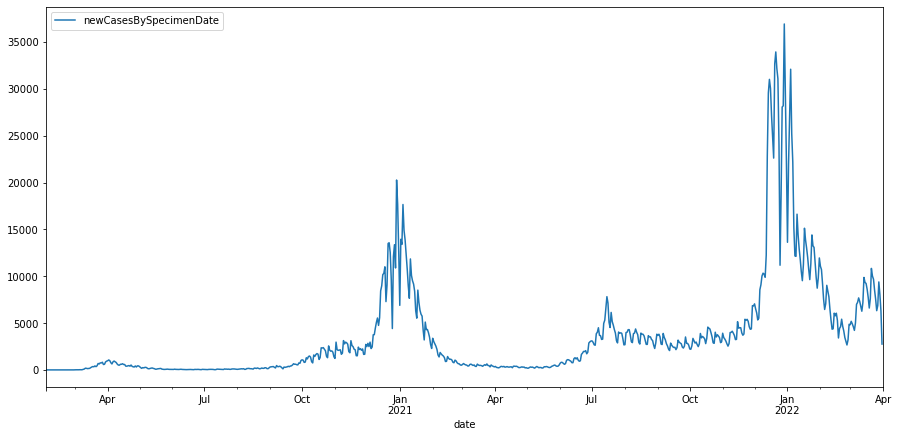

In [23]:
# New cases for London
region.date = pd.to_datetime(region.date, infer_datetime_format=True)
df = region[['newCasesBySpecimenDate', 'date']]
df = df.set_index('date')
df.plot(figsize=(15, 7))

In [24]:
# New cases for boroughs

ulta_sub = ulta[['areaName', 'date', 'newCasesBySpecimenDate']]
ulta_sub.date = pd.to_datetime(ulta_sub.date, infer_datetime_format=True)
ulta_sub.set_index('date')
table = pd.pivot_table(ulta_sub, values='newCasesBySpecimenDate', index='date',
                       columns=['areaName'])
table.head()

/var/folders/hy/vpm71bsj40g8d9qhfg95kmtc0000gn/T/ipykernel_39087/612427676.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ulta_sub.date = pd.to_datetime(ulta_sub.date, infer_datetime_format=True)


areaName,Aberdeen City,Aberdeenshire,Angus,Antrim and Newtownabbey,Ards and North Down,Argyll and Bute,"Armagh City, Banbridge and Craigavon",Barking and Dagenham,Barnet,Barnsley,...,Westminster,Wigan,Wiltshire,Windsor and Maidenhead,Wirral,Wokingham,Wolverhampton,Worcestershire,Wrexham,York
date,,,,,,,,,,,,,,,,,,,,,
2020-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


### England -- Scotland

In [25]:
table_total = table[
    ['City of Edinburgh', 'Glasgow City', 'Newcastle upon Tyne', 'Camden',
     'Westminster', 'York']]
table_sco = table[['City of Edinburgh', 'Glasgow City']]
table_eng = table[['Newcastle upon Tyne', 'Camden', 'Westminster', 'York']]
table_eng

areaName,Newcastle upon Tyne,Camden,Westminster,York
date,,,,
2020-01-30,NaN,NaN,NaN,1.0
2020-01-31,NaN,NaN,NaN,0.0
2020-02-01,NaN,NaN,NaN,0.0
2020-02-02,NaN,NaN,NaN,0.0
2020-02-03,NaN,NaN,NaN,0.0
...,...,...,...,...
2022-03-27,299.0,189.0,167.0,212.0
2022-03-28,426.0,307.0,251.0,301.0
2022-03-29,336.0,256.0,214.0,250.0


<AxesSubplot:xlabel='date'>

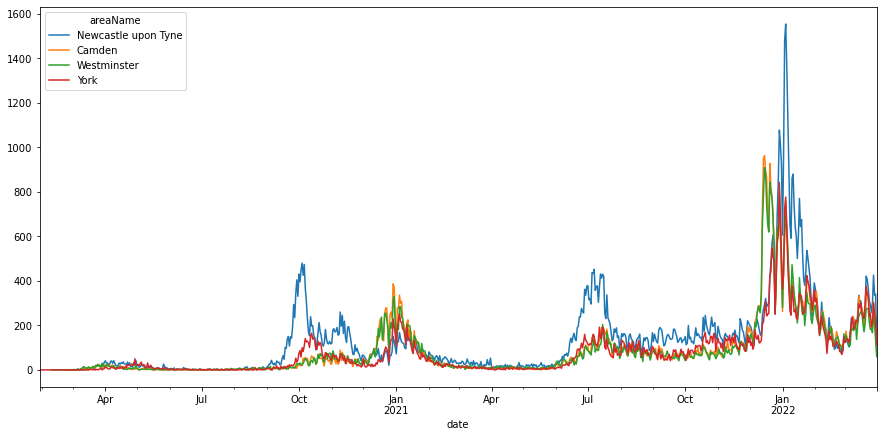

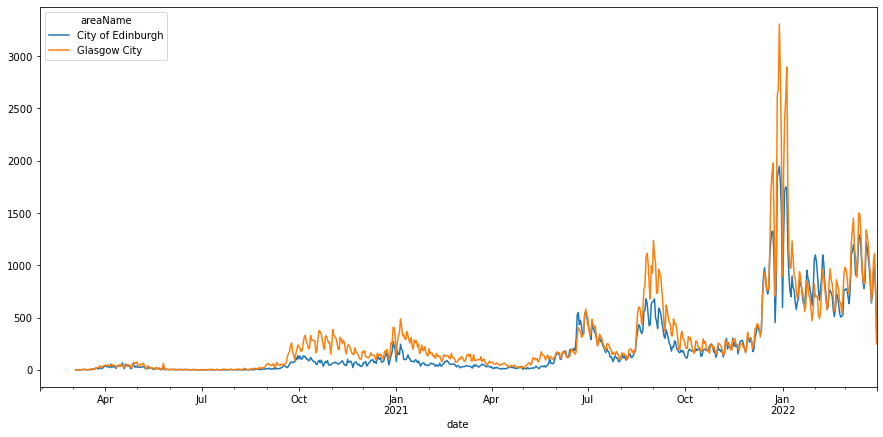

In [26]:
table_eng.plot(figsize=(15, 7))
table_sco.plot(figsize=(15, 7))

<AxesSubplot:xlabel='date'>

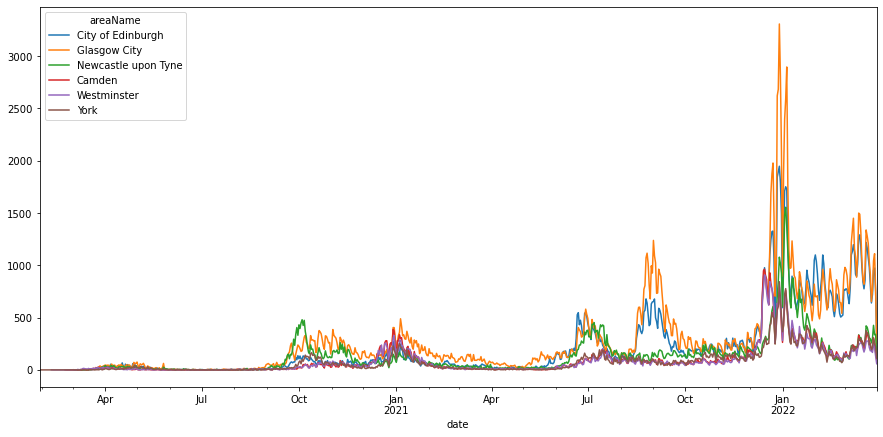

In [27]:
table_total.plot(figsize=(15, 7))

### Correlations

In [28]:
covid_daily.corr()

,daily_cases,daily_deaths,FirstDose,SecondDose,ThirdDose,covidOccupiedMVBeds,hospitalCases,newAdmissions
daily_cases,1.000000,0.177747,-0.381691,-0.388733,0.604147,0.081408,0.385724,0.544503
daily_deaths,0.177747,1.000000,0.286063,-0.345090,-0.108002,0.866628,0.875417,0.787575
FirstDose,-0.381691,0.286063,1.000000,0.259601,-0.305837,0.396096,0.119968,-0.068151
SecondDose,-0.388733,-0.345090,0.259601,1.000000,-0.280382,-0.416107,-0.541235,-0.476102
ThirdDose,0.604147,-0.108002,-0.305837,-0.280382,1.000000,-0.137189,-0.069908,0.023572
covidOccupiedMVBeds,0.081408,0.866628,0.396096,-0.416107,-0.137189,1.000000,0.881903,0.722927
hospitalCases,0.385724,0.875417,0.119968,-0.541235,-0.069908,0.881903,1.000000,0.914498
newAdmissions,0.544503,0.787575,-0.068151,-0.476102,0.023572,0.722927,0.914498,1.000000


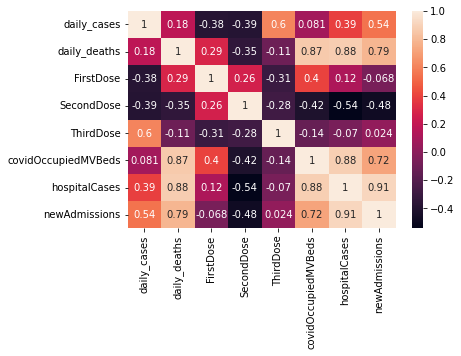

In [29]:
corrMatrix = covid_daily.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [30]:
covid_daily.to_csv('mergedCase.csv')
covid.to_csv('mergedCaseAll.csv')

# Cases by age

In [31]:
cases_age = london_covid[['date', 'daily_cases_age']]
cases_age = cases_age.explode('daily_cases_age')
cases_age_split = cases_age['daily_cases_age'].apply(pd.Series)
cases_age_split.columns

Index([0, 'age', 'cases', 'rollingSum', 'rollingRate'], dtype='object')

In [32]:
cols = [cases_age['date'], cases_age_split['age'], cases_age_split['cases'],
        cases_age_split['rollingRate'], cases_age_split['rollingSum']]
cases_age = pd.concat(cols, axis=1)
cases_age.dropna(inplace=True)
cases_age

,date,age,cases,rollingRate,rollingSum
5,2022-04-03,00_04,53.0,129.7,773.0
5,2022-04-03,00_59,3116.0,480.4,36024.0
5,2022-04-03,05_09,93.0,183.2,1111.0
5,2022-04-03,10_14,86.0,252.7,1392.0
5,2022-04-03,15_19,107.0,312.4,1482.0
...,...,...,...,...,...
486,2020-12-08,70_74,50.0,110.9,311.0
486,2020-12-08,75_79,41.0,116.1,228.0
486,2020-12-08,80_84,39.0,135.1,204.0
486,2020-12-08,85_89,23.0,166.3,156.0


In [33]:
deaths_age = london_covid[['date', 'daily_deaths_age']]
deaths_age = deaths_age.explode('daily_deaths_age')
deaths_age_split = deaths_age['daily_deaths_age'].apply(pd.Series)
deaths_age_split.columns

Index([0, 'age', 'deaths', 'rollingSum', 'rollingRate'], dtype='object')

In [34]:
cols = [deaths_age['date'], deaths_age_split['age'], deaths_age_split['deaths'],
        deaths_age_split['rollingRate'], deaths_age_split['rollingSum']]
deaths_age = pd.concat(cols, axis=1)
deaths_age.dropna(inplace=True)
deaths_age

,date,age,deaths,rollingRate,rollingSum
5,2022-04-03,00_04,0.0,0.0,0.0
5,2022-04-03,00_59,1.0,0.1,8.0
5,2022-04-03,05_09,0.0,0.0,0.0
5,2022-04-03,10_14,0.0,0.0,0.0
5,2022-04-03,15_19,0.0,0.0,0.0
...,...,...,...,...,...
486,2020-12-08,70_74,0.0,7.1,20.0
486,2020-12-08,75_79,4.0,17.8,35.0
486,2020-12-08,80_84,7.0,21.9,33.0
486,2020-12-08,85_89,9.0,45.8,43.0


In [35]:
vac_age = london_covid[['date', 'vaccination_age']]
vac_age = vac_age.explode('vaccination_age')
vac_age_split = vac_age['vaccination_age'].apply(pd.Series)
vac_age_split.columns

Index(['age', 'VaccineRegisterPopulationByVaccinationDate',
       'cumPeopleVaccinatedCompleteByVaccinationDate',
       'newPeopleVaccinatedCompleteByVaccinationDate',
       'cumPeopleVaccinatedFirstDoseByVaccinationDate',
       'newPeopleVaccinatedFirstDoseByVaccinationDate',
       'cumPeopleVaccinatedSecondDoseByVaccinationDate',
       'newPeopleVaccinatedSecondDoseByVaccinationDate',
       'cumPeopleVaccinatedThirdInjectionByVaccinationDate',
       'newPeopleVaccinatedThirdInjectionByVaccinationDate',
       'cumVaccinationFirstDoseUptakeByVaccinationDatePercentage',
       'cumVaccinationCompleteCoverageByVaccinationDatePercentage',
       'cumVaccinationSecondDoseUptakeByVaccinationDatePercentage',
       'cumVaccinationThirdInjectionUptakeByVaccinationDatePercentage'],
      dtype='object')

In [36]:
cols = [
    vac_age['date'],
    vac_age_split['age'],
    vac_age_split['cumVaccinationFirstDoseUptakeByVaccinationDatePercentage'],
    vac_age_split['cumVaccinationCompleteCoverageByVaccinationDatePercentage'],
    vac_age_split['cumVaccinationSecondDoseUptakeByVaccinationDatePercentage']
]
# concat these columns together
vac_age = pd.concat(cols, axis=1)
vac_age

,date,age,cumVaccinationFirstDoseUptakeByVaccinationDatePercentage,cumVaccinationCompleteCoverageByVaccinationDatePercentage,cumVaccinationSecondDoseUptakeByVaccinationDatePercentage
1,2022-04-07,12_15,44.3,25.1,25.1
1,2022-04-07,16_17,54.8,40.5,40.5
1,2022-04-07,18_24,63.3,54.7,54.7
1,2022-04-07,25_29,65.0,59.9,59.9
1,2022-04-07,30_34,62.9,58.8,58.8
...,...,...,...,...,...
486,2020-12-08,70_74,0.0,0.0,0.0
486,2020-12-08,75_79,0.0,0.0,0.0
486,2020-12-08,80_84,0.1,0.0,0.0
486,2020-12-08,85_89,0.1,0.0,0.0


<AxesSubplot:title={'center':'Cumlative Percentage of 1st Dose Vaccination By Age Group'}, xlabel='date'>

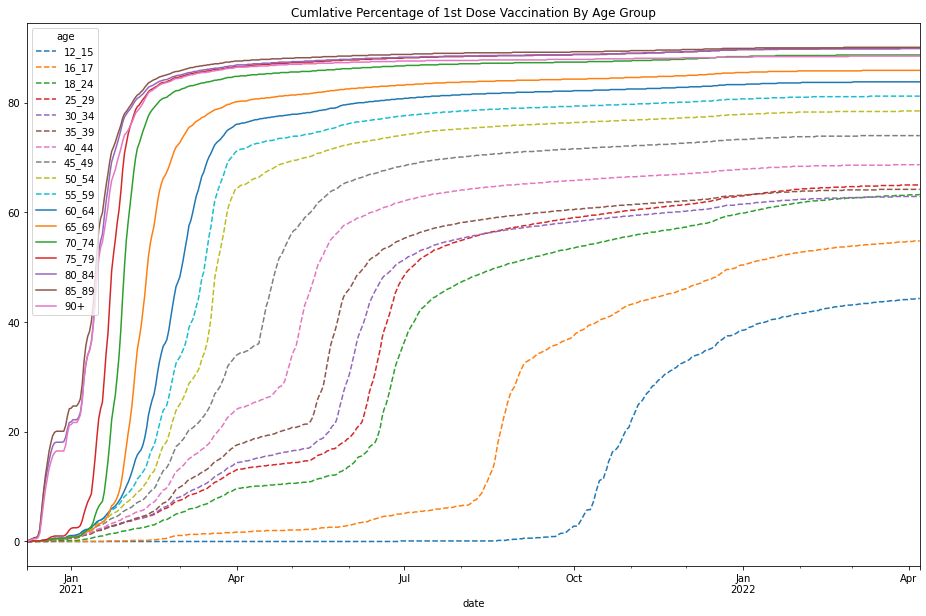

In [37]:
table = pd.pivot_table(vac_age, values='cumVaccinationFirstDoseUptakeByVaccinationDatePercentage', index='date', columns='age')
table.plot(style=['--' for _ in range(10)], figsize=(16, 10),
           title='Cumlative Percentage of 1st Dose Vaccination By Age Group')

In [38]:
cases_age.reset_index(inplace=True)
idx = cases_age.loc[
    (cases_age['age'] == '00_59') | (cases_age['age'] == '60+')].index
cases_age_md = cases_age.drop(index=idx)
cases_age_md

,index,date,age,cases,rollingRate,rollingSum
0,5,2022-04-03,00_04,53.0,129.7,773.0
2,5,2022-04-03,05_09,93.0,183.2,1111.0
3,5,2022-04-03,10_14,86.0,252.7,1392.0
4,5,2022-04-03,15_19,107.0,312.4,1482.0
5,5,2022-04-03,20_24,268.0,519.6,2892.0
...,...,...,...,...,...,...
10117,486,2020-12-08,70_74,50.0,110.9,311.0
10118,486,2020-12-08,75_79,41.0,116.1,228.0
10119,486,2020-12-08,80_84,39.0,135.1,204.0
10120,486,2020-12-08,85_89,23.0,166.3,156.0


<AxesSubplot:xlabel='date'>

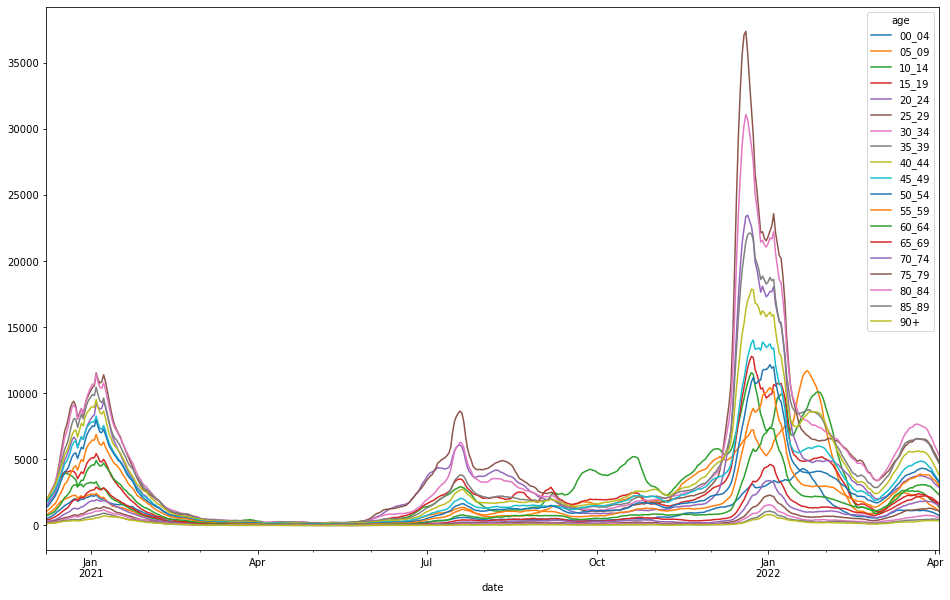

In [39]:
table = pd.pivot_table(cases_age_md, values='rollingSum', index='date',
                       columns='age')
table.plot(figsize=(16, 10))

In [40]:
deaths_age.reset_index(inplace=True)
idx = deaths_age.loc[
    (deaths_age['age'] == '00_59') | (deaths_age['age'] == '60+')].index
deaths_age_md = deaths_age.drop(index=idx)
deaths_age_md

,index,date,age,deaths,rollingRate,rollingSum
0,5,2022-04-03,00_04,0.0,0.0,0.0
2,5,2022-04-03,05_09,0.0,0.0,0.0
3,5,2022-04-03,10_14,0.0,0.0,0.0
4,5,2022-04-03,15_19,0.0,0.0,0.0
5,5,2022-04-03,20_24,0.0,0.0,0.0
...,...,...,...,...,...,...
10117,486,2020-12-08,70_74,0.0,7.1,20.0
10118,486,2020-12-08,75_79,4.0,17.8,35.0
10119,486,2020-12-08,80_84,7.0,21.9,33.0
10120,486,2020-12-08,85_89,9.0,45.8,43.0


<AxesSubplot:xlabel='date'>

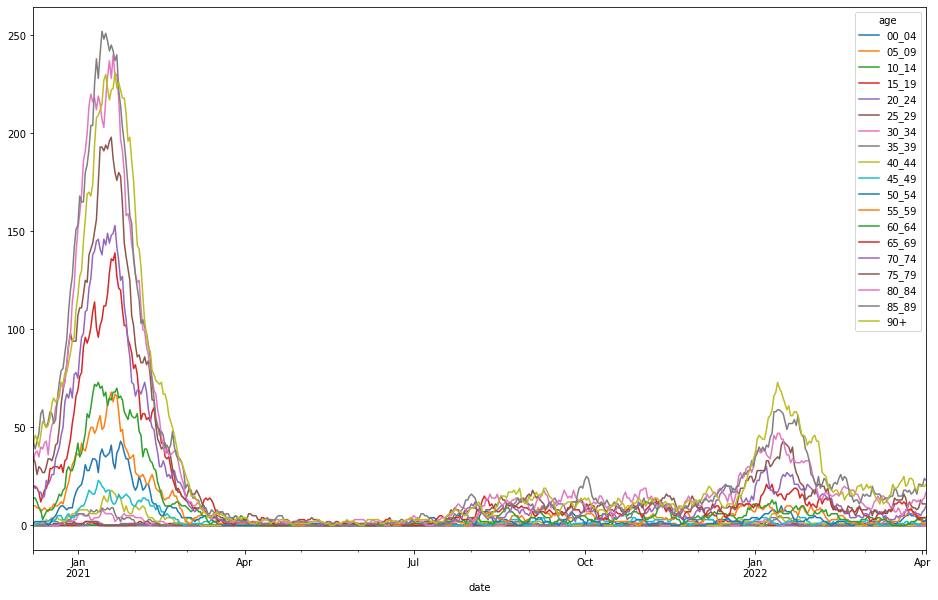

In [41]:
table = pd.pivot_table(deaths_age_md, values='rollingSum', index='date',
                       columns='age')
table.plot(figsize=(16, 10))

# Vaccinations

<AxesSubplot:xlabel='date'>

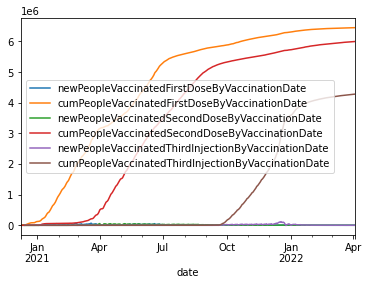

In [42]:
vac.date = pd.to_datetime(vac.date, infer_datetime_format=True)
vac.set_index('date').plot()

In [43]:
vac.columns

Index(['areaType', 'areaName', 'areaCode', 'date',
       'newPeopleVaccinatedFirstDoseByVaccinationDate',
       'cumPeopleVaccinatedFirstDoseByVaccinationDate',
       'newPeopleVaccinatedSecondDoseByVaccinationDate',
       'cumPeopleVaccinatedSecondDoseByVaccinationDate',
       'newPeopleVaccinatedThirdInjectionByVaccinationDate',
       'cumPeopleVaccinatedThirdInjectionByVaccinationDate'],
      dtype='object')

<AxesSubplot:xlabel='date'>

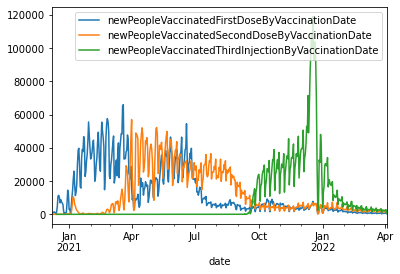

In [44]:
vac_sub = vac[['newPeopleVaccinatedFirstDoseByVaccinationDate',
               'newPeopleVaccinatedSecondDoseByVaccinationDate',
               'newPeopleVaccinatedThirdInjectionByVaccinationDate',
               'date']]
vac_sub.set_index('date').plot()

<AxesSubplot:xlabel='date'>

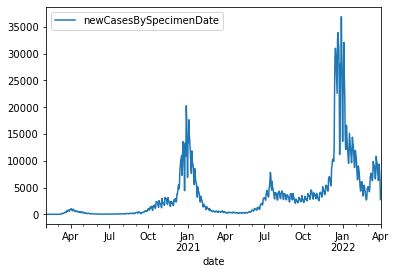

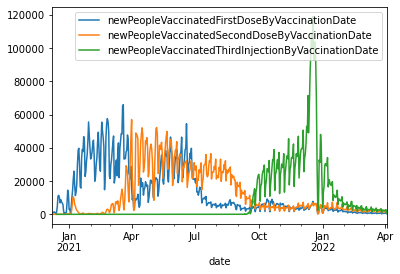

In [45]:
df.plot()
vac_sub.set_index('date').plot()

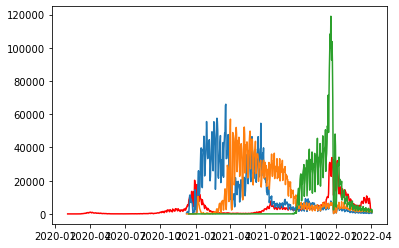

In [46]:
figsize = (15, 7)
plt.plot(df, color='r', label='sin')
plt.plot(vac_sub.set_index('date'), label='cos')